# Manipulating font data in Flat

By [Allison Parrish](https://www.decontextualize.com/)

> NOTE: This is a draft version, more notes and explanation TK.

This is a short notebook showing some techniques for loading data from TrueType/OpenType font files with [Flat](https://xxyxyz.org/flat) and then doing weird things with it. Intended as a follow up to [this notebook on asemic writing with Flat](https://gist.github.com/aparrish/2209201ed3ecf35332d96264e66ce681)—some of the material in this notebook won't make sense unless you've gone through that notebook first.

Make sure you've installed Flat before you continue:

In [2]:
!pip install flat

  Using cached https://files.pythonhosted.org/packages/6c/9d/1a99302306ff1dda23caa25a4a907a512509fdaeed511866e4d3eb30f289/Flat-0.3.tar.gz
  Stored in directory: /Users/allison/Library/Caches/pip/wheels/5c/27/82/6951d0e0e06195b3aee1b2d1789a97017e17517b4b6eb9c0ea
Successfully built flat


Then we'll import some important stuff from Flat:

In [1]:
from flat import document, rgba, font, strike, shape
from flat.command import moveto, quadto, curveto, lineto, closepath

And some functions from `numpy` which we'll use for generating random numbers.

In [2]:
from numpy.random import uniform, normal, choice

In [3]:
from math import pi

In [4]:
from IPython.display import Image, display
def show(page):
    display(Image(page.image(kind='rgba').png()))

## Preliminaries: Matrix transformations on paths

Flat has a concept of a "path," which is a Python list of `command`s. Five such commands are supported:

* `moveto(x, y)`: Moves pen to x, y.
* `lineto(x, y)`: Moves pen to x, y, drawing a line along the way.
* `quadto(x1, y1, x, y)`: Draws a quadratic Bezier curve from current pen position to x, y, using control point x1, y1.
* `curveto(x1, y1, x2, y2, x, y)`: Draws a cubic Bezier curve from current point to x, y, using control points x1, y1 and x2, y2.
* `closepath`: Closes the current subpath.

To draw a path, create a list of `command`s and pass them to a `shape` object's `path` command. For example, to draw a little strange triangle:

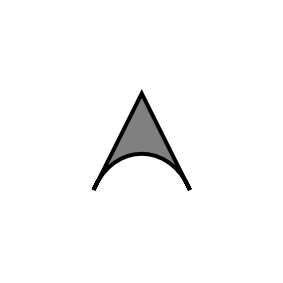

In [5]:
d = document(100, 100, 'mm') # create a document 100mm x 100mm (can replace 'mm' with 'pt')
page = d.addpage() # add a page
pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(128, 128, 128, 255)).width(4)
my_cmds = [moveto(50, 33),
           lineto(67, 67),
           curveto(60, 50, 40, 50, 33, 67),
           closepath]
tri_path = pen.path(my_cmds)
page.place(tri_path)
show(page) # show the page

A potential drawback to specifying paths like this is that the coordinates are hard-coded, making it difficult to do things like draw the path at a different size or at a different location on the canvas. To mitigate this drawback, Flat supports a "transformation matrix"—a way to mathematically manipulate the points in a path to produce effects like scale, translation, rotation, etc. (I recommend this [helpful introduction to the transformation matrix](https://www.alanzucconi.com/2016/02/10/tranfsormation-matrix/)—not specific to Flat, but the concepts are the same regardless.) In Flat, `command` objects each support a `.transform()` method to perform matrix transformations on individual commands, but it's a bit fiddly to use in practice. I wrote the "helper functions" in the cell below to make it easier to perform these transformations on Flat paths (i.e., lists of commands).

In [6]:
from copy import copy
from math import sin, cos

# scales the path by the same factor along both axes
def scale(x, cmds):
    return [copy(cmd).transform(x, 0, 0, x, 0, 0) for cmd in cmds]

# scales the path by the given values on the x and y axes
def scalexy(x, y, cmds):
    return [copy(cmd).transform(x, 0, 0, y, 0, 0) for cmd in cmds]

# translates (moves) the path by x and y units in the respective axes
def translate(x, y, cmds):
    return [copy(cmd).transform(1, 0, 0, 1, x, y) for cmd in cmds]

# rotates the path around the origin with the given angle (in radians)
def rotate(theta, cmds):
    return [copy(cmd).transform(cos(theta), -sin(theta),
                               sin(theta), cos(theta),
                               0, 0) for cmd in cmds]

To transform a path, call this function with the path as a parameter. It will return a new path (i.e., list of `command`s) with the transformation applied to copies of the commands in the original path. (The commands in the original path will be unchanged.) The code below shows the effect of the commands, with the transformed shapes drawn with slight transparency:

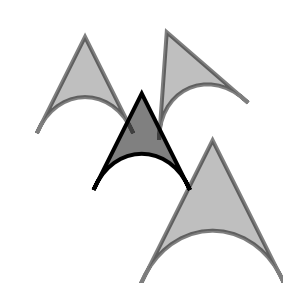

In [7]:
d = document(100, 100, 'mm')
page = d.addpage()
pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(128, 128, 128, 255)).width(4)
alpha_pen = shape().stroke(rgba(0, 0, 0, 128)).fill(rgba(0, 0, 0, 64)).width(4)

my_cmds = [moveto(50, 33),
           lineto(67, 67),
           curveto(60, 50, 40, 50, 33, 67),
           closepath]
page.place(pen.path(my_cmds))

# move the path up and to the left
translated_cmds = translate(-20, -20, my_cmds)
page.place(alpha_pen.path(translated_cmds))

# scale the path by a factor of 1.5x
scaled_cmds = scale(1.5, my_cmds)
page.place(alpha_pen.path(scaled_cmds))

# rotate the path
rotated_cmds = rotate(pi * 0.125, my_cmds)
page.place(alpha_pen.path(rotated_cmds))

show(page)

You'll notice that all of these transformations use the origin (i.e., coordinate `(0, 0)`) as the "center" of the transformation, so (e.g.) the "center" of the `rotate()` transformation is in the upper left-hand corner of the screen. For this reason, when specifying paths for use with transformations, programmers often intentionally center the figure around the origin: 

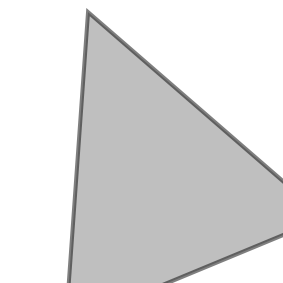

In [8]:
d = document(100, 100, 'mm')
page = d.addpage()
pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(128, 128, 128, 255)).width(4)
alpha_pen = shape().stroke(rgba(0, 0, 0, 128)).fill(rgba(0, 0, 0, 64)).width(4)

my_cmds = [moveto(0, -33),
           lineto(33, 33),
           lineto(-33, 33),
           closepath]

scaled_cmds = scale(1.5, my_cmds)
rotated_cmds = rotate(pi * 0.125, scaled_cmds)
translated_cmds = translate(50, 50, rotated_cmds)

page.place(alpha_pen.path(translated_cmds))

show(page)

Example nesting transformations with a loop:

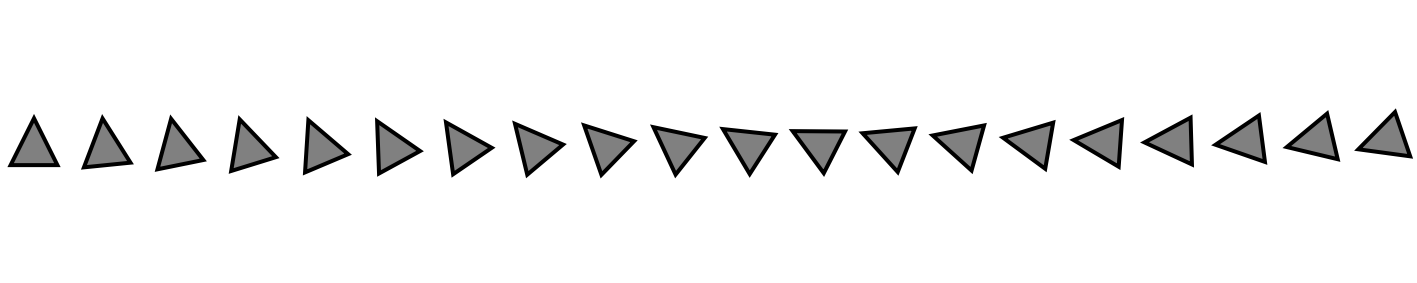

In [10]:
d = document(500, 100, 'mm')
page = d.addpage()
pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(128, 128, 128, 255)).width(4)
alpha_pen = shape().stroke(rgba(0, 0, 0, 128)).fill(rgba(0, 0, 0, 64)).width(4)

my_cmds = [moveto(0, -33),
           lineto(33, 33),
           lineto(-33, 33),
           closepath]

for i in range(20):
    this_cmds = translate(12 + (i * 25), 50, scale(0.25, rotate(i * 0.1, my_cmds)))
    page.place(pen.path(this_cmds))

show(page)

## Drawing strings with flat

Flat has a handful of helpful functions for drawing strings to the screen with a given font. You need to download the font file for the font you want to use, put it in the same directory as this notebook, and then call `font.open` as below. We'll use a font from Google's [Noto collection](https://www.google.com/get/noto/).

In [11]:
f = font.open("./NotoSans-Regular.ttf")

Drawing a string to the screen. The `strike()` call is like `shape()` but for text; `.size()`'s parameters set the font size and leading, respectively; `.frame()` on the placement reflows the text in an invisible rectangle with the given coordinates and size.

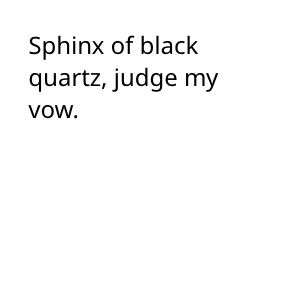

In [12]:
d = document(100, 100, 'mm')
page = d.addpage()
pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(128, 128, 128, 255)).width(4)
text_pen = strike(f).color(rgba(0, 0, 0, 255)).size(24, 32)
page.place(text_pen.text("Sphinx of black quartz, judge my vow.")).frame(10, 10, 80, 80)
show(page)

## Digging deeper into the font

The font object has more secrets in store: we can access the geometry of glyphs in the font directly. Each glyph has an index; access the glyph at a particular index like so:

In [13]:
f.glyph(42)

To see what one of these glyphs looks like, I made a helper function:

In [14]:
def drawglyphquick(f, cmds, size=50, xoffset=33, yoffset=67):
    factor = (1 / f.density) * 50
    d = document(100, 100, 'mm') # create a document 100mm x 100mm (can replace 'mm' with 'pt')
    page = d.addpage() # add a page
    pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(0, 0, 0, 128))
    glyph_path = pen.path(translate(33, 67, scale(factor, cmds)))
    page.place(glyph_path)
    show(page) # show the page

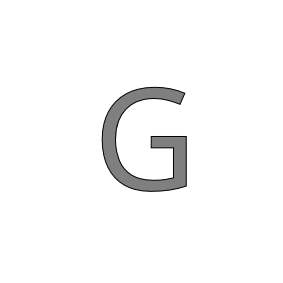

In [15]:
drawglyphquick(f, f.glyph(42))

Try replacing `42` with some other number! But how do you know which character corresponds to which glyph index? First, get the "order" of the character (e.g., its Unicode codepoint):

In [16]:
ord("a")

97

... and then look it up in the font's `charmap`:

In [17]:
f.charmap[ord("a")]

68

So, to draw a lower-case `a`:

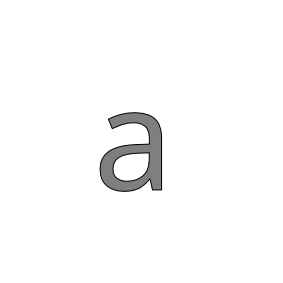

In [18]:
drawglyphquick(f, f.glyph(f.charmap[ord("a")]))

The font also stores "advances" for each character, i.e., how much the pen should move horizontally after drawing the character.

In [19]:
f.advances[f.charmap[ord("a")]]

561

These two helper functions get the path commands for a given character and the advance for a given character:

In [20]:
def glyphcommands(f, ch):
    return [copy(cmd) for cmd in f.glyph(f.charmap[ord(ch)])]
def advancefor(f, ch):
    return f.advances[f.charmap[ord(ch)]]

In [21]:
glyphcommands(f, "z")

Now we can analyze which letters are most "complicated" (i.e., have the most commands in their path data):

In [22]:
alphabet = "abcdefghijklmnopqrstuvwxyz"

In [23]:
for ch in alphabet:
    print(ch, len(glyphcommands(f, ch)))

a 33
b 29
c 21
d 30
e 27
f 22
g 35
h 19
i 16
j 24
k 20
l 6
m 28
n 18
o 22
p 31
q 30
r 18
s 32
t 23
u 18
v 16
w 31
x 14
y 23
z 12


And draw a visualization of this:

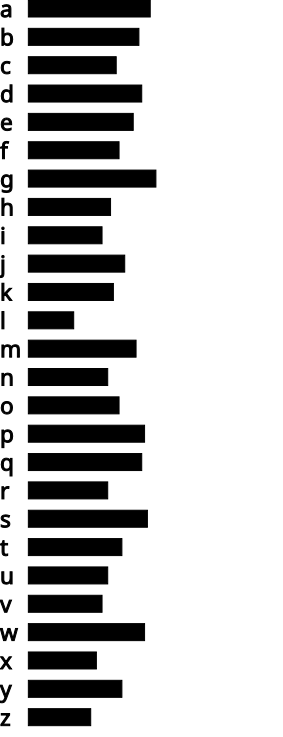

In [24]:
d = document(100, 260, 'mm')
page = d.addpage()
letter_pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(0, 0, 0, 255))
bar_pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(0, 0, 0, 255))
factor = (1 / f.density) * 8
for i in range(len(alphabet)):
    ch = alphabet[i]
    bar_len = len(glyphcommands(f, ch))
    letter_cmds = translate(0, (i*10)+6, scale(factor, glyphcommands(f, ch)))
    glyph_path = letter_pen.path(letter_cmds)
    bar = bar_pen.rectangle(10, i*10, 10 + bar_len, 6)
    page.place(glyph_path)
    page.place(bar)
show(page)

### Rendering a string "by hand"

Using `glyphcommands()` and `advancefor()`, you can draw an entire string on the screen. It moves the pen by the character's advance on the x axis and draws the next character at the new position, using `translate()` to translate the path commands.

Drawbacks of this approach:

* Only works with left-to-right writing
* Doesn't take into account kerning

The tasks of shaping text and rasterizing it are very sophisticated! See [HarfBuzz](https://en.wikipedia.org/wiki/HarfBuzz), [FreeType](https://www.freetype.org/).

Fonts have a `density`, which gives information on how the units of distance in the font's path data correspond to the actual height of a character. We'll use this to get a scaling factor that we apply with `scale()` to the path commands.

In [25]:
s = "quartzy foxes"

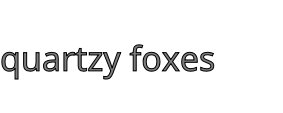

In [26]:
d = document(100, 40, 'mm')
page = d.addpage()
pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(0, 0, 0, 128))
factor = (1 / f.density) * 12
cx = 0
for ch in s:
    cmds = translate(cx, 25, scale(factor, glyphcommands(f, ch)))
    glyph_path = pen.path(cmds)
    page.place(glyph_path)
    cx += advancefor(f, ch) * factor
show(page)

We can introduce some random variation into this process:

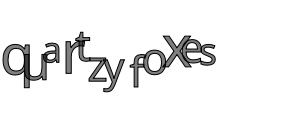

In [27]:
d = document(100, 40, 'mm')
page = d.addpage()
pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(0, 0, 0, 128))
factor = (1 / f.density) * 12
cx = 0
for ch in s:
    cmds = translate(cx, normal(25, 5), scale(factor + uniform(0, factor), glyphcommands(f, ch)))
    glyph_path = pen.path(cmds)
    page.place(glyph_path)
    cx += advancefor(f, ch) * factor
show(page)

Uniformly distributed letters:

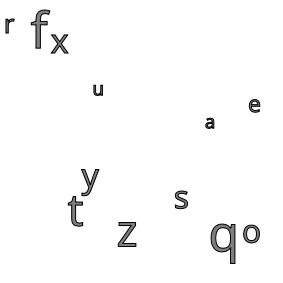

In [28]:
d = document(100, 100, 'mm')
page = d.addpage()
pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(0, 0, 0, 128))
factor = (1 / f.density) * 12
for ch in s:
    cmds = translate(uniform(90), uniform(90), scale(factor * uniform(0.5, 1.5), glyphcommands(f, ch)))
    glyph_path = pen.path(cmds)
    page.place(glyph_path)
show(page)

Or just rendering the characters as their advances:

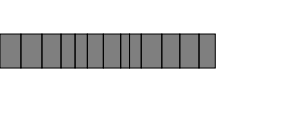

In [29]:
d = document(100, 40, 'mm')
page = d.addpage()
pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(0, 0, 0, 128))
factor = (1 / f.density) * 12
cx = 0
for ch in s:
    advance = advancefor(f, ch) * factor
    rect = pen.rectangle(cx, 12, advance, 12)
    page.place(rect)
    cx += advance
show(page)

### Reinterpreting commands

Of course, nothing is forcing us to render these commands as written! We can modify them and reinterpret them.

In [30]:
cmds = glyphcommands(f, "b")

In [32]:
from flat.command import moveto, quadto, curveto, lineto, closepath
for cmd in cmds:
    if type(cmd) in (moveto, lineto):
        print(type(cmd), cmd.x, cmd.y)
    elif type(cmd) == quadto:
        print(type(cmd), cmd.x1, cmd.y1, cmd.x, cmd.y)
    elif type(cmd) == curveto:
        print(type(cmd), cmd.x1, cmd.y1, cmd.x2, cmd.y2, cmd.x, cmd.y)
    elif type(cmd) is type(closepath):
        print(type(cmd))

<class 'flat.command.moveto'> 85 -760
<class 'flat.command.lineto'> 173 -760
<class 'flat.command.lineto'> 173 -575
<class 'flat.command.quadto'> 173 -541 171.5 -511.5
<class 'flat.command.quadto'> 170 -482 168 -465
<class 'flat.command.lineto'> 173 -465
<class 'flat.command.quadto'> 196 -499 236.0 -522.0
<class 'flat.command.quadto'> 276 -545 339 -545
<class 'flat.command.quadto'> 439 -545 499.5 -475.5
<class 'flat.command.quadto'> 560 -406 560 -268
<class 'flat.command.quadto'> 560 -130 499.0 -60.0
<class 'flat.command.quadto'> 438 10 339 10
<class 'flat.command.quadto'> 276 10 236.0 -13.0
<class 'flat.command.quadto'> 196 -36 173 -68
<class 'flat.command.lineto'> 166 -68
<class 'flat.command.lineto'> 148 0
<class 'flat.command.lineto'> 85 0
<class 'flat.command.lineto'> 85 -760
<class 'flat.command.closepath'>
<class 'flat.command.moveto'> 469 -269
<class 'flat.command.quadto'> 469 -472 324 -472
<class 'flat.command.quadto'> 238 -472 205.5 -423.0
<class 'flat.command.quadto'> 173 -3

Adding normal noise to the points:

In [33]:
new_cmds = []
for cmd in glyphcommands(f, "a"):
    stddev = f.density * 0.02
    if type(cmd) in (moveto, lineto, quadto, curveto):
        cmd.x += normal(0, stddev)
        cmd.y += normal(0, stddev)
    if type(cmd) in (quadto, curveto):
        cmd.x1 += normal(0, stddev)
        cmd.y1 += normal(0, stddev)
    if type(cmd) == curveto:
        cmd.x1 += normal(0, stddev)
        cmd.y1 += normal(0, stddev)
    new_cmds.append(cmd)

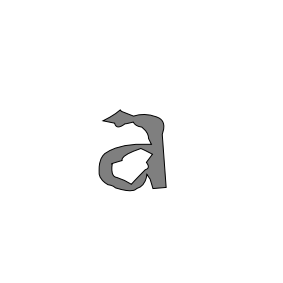

In [34]:
factor = (1 / f.density) * 50
d = document(100, 100, 'mm') # create a document 100mm x 100mm (can replace 'mm' with 'pt')
page = d.addpage() # add a page
pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(0, 0, 0, 128))
glyph_path = pen.path(translate(33, 67, scale(factor, new_cmds)))
page.place(glyph_path)
show(page) # show the page

"Stretching" the points:

In [35]:
cmds = glyphcommands(f, "a")
max_y = max([cmd.y for cmd in cmds if type(cmd) in (lineto, moveto, quadto, curveto)])
min_y = min([cmd.y for cmd in cmds if type(cmd) in (lineto, moveto, quadto, curveto)])
mid = (min_y + max_y) / 2
new_cmds = []
for cmd in cmds:
    if type(cmd) in (moveto, lineto, quadto, curveto):
        if cmd.y > mid:
            cmd.y += 200
            if type(cmd) in (quadto, curveto):
                cmd.y1 += 200
            if type(cmd) == curveto:
                cmd.y2 += 200
    new_cmds.append(cmd)

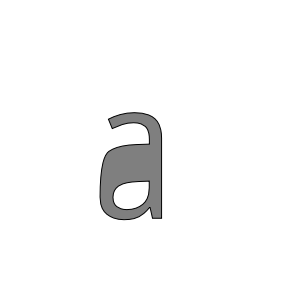

In [36]:
factor = (1 / f.density) * 50
d = document(100, 100, 'mm')
page = d.addpage()
pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(0, 0, 0, 128))
glyph_path = pen.path(translate(33, 67, scale(factor, new_cmds)))
page.place(glyph_path)
show(page)

#### Writing mangled characters

Put the code to mangle an individual character in a function:

In [37]:
def mangle(f, ch):
    cmds = glyphcommands(f, ch)
    if len(cmds) == 0:
        return cmds
    max_y = max([cmd.y for cmd in cmds if type(cmd) in (lineto, moveto, quadto, curveto)])
    min_y = min([cmd.y for cmd in cmds if type(cmd) in (lineto, moveto, quadto, curveto)])
    mid = (min_y + max_y) / 2
    new_cmds = []
    pop = uniform(0, 400)
    for cmd in cmds:
        if type(cmd) in (moveto, lineto, quadto, curveto):
            if cmd.y < mid:
                cmd.y -= pop
                if type(cmd) in (quadto, curveto):
                    cmd.y1 -= pop
                if type(cmd) == curveto:
                    cmd.y2 -= pop
        new_cmds.append(cmd)
    return new_cmds

And then call the function on each character in the string, advancing by the `advance`:

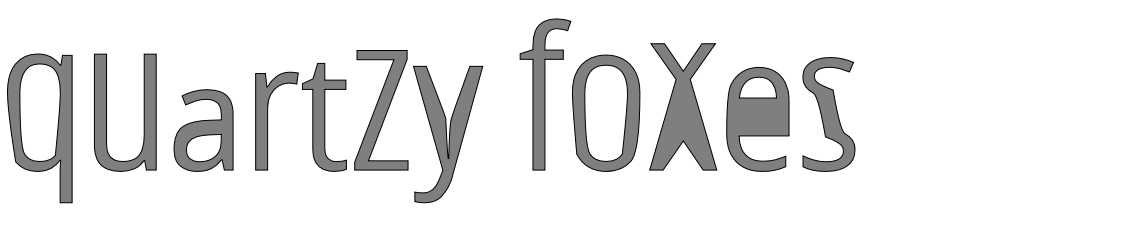

In [38]:
d = document(400, 80, 'mm')
page = d.addpage()
pen = shape().stroke(rgba(0, 0, 0, 255)).fill(rgba(0, 0, 0, 128))
factor = (1 / f.density) * 48
cx = 0
for ch in s:
    cmds = translate(cx, 60, scale(factor, mangle(f, ch)))
    glyph_path = pen.path(cmds)
    page.place(glyph_path)
    cx += advancefor(f, ch) * factor
show(page)

Or, instead of using the original command, we can "reinterpret" it as another command. This example draws lines instead of curves and circles instead of lines:

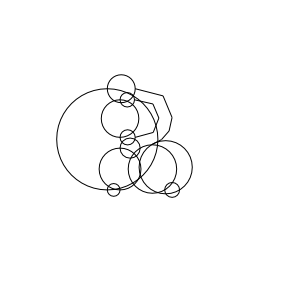

In [39]:
from math import sqrt
d = document(100, 100, 'mm')
page = d.addpage()
pen = shape().stroke(rgba(0, 0, 0, 255)).nofill()
factor = (1 / f.density) * 50
cx = 0
cy = 0
transformed_cmds = translate(33, 67, scale(factor, glyphcommands(f, "R")))
for cmd in transformed_cmds:
    if type(cmd) == lineto:
        radius = sqrt(pow(cx - cmd.x, 2) + pow(cy - cmd.y, 2)) * 0.5
        page.place(pen.circle((cx + cmd.x) / 2, (cy + cmd.y) / 2, radius))
    elif type(cmd) in (curveto, quadto):
        page.place(pen.line(cx, cy, cmd.x, cmd.y))
    if type(cmd) != type(closepath):
        cx = cmd.x
        cy = cmd.y
show(page)